## Library

In [2]:
import os
import numpy as np
import pandas as pd
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from matplotlib.patches import Polygon
from math import ceil

##  1 siphon信息的可视化

### 1.1 曲率・扭率可视化

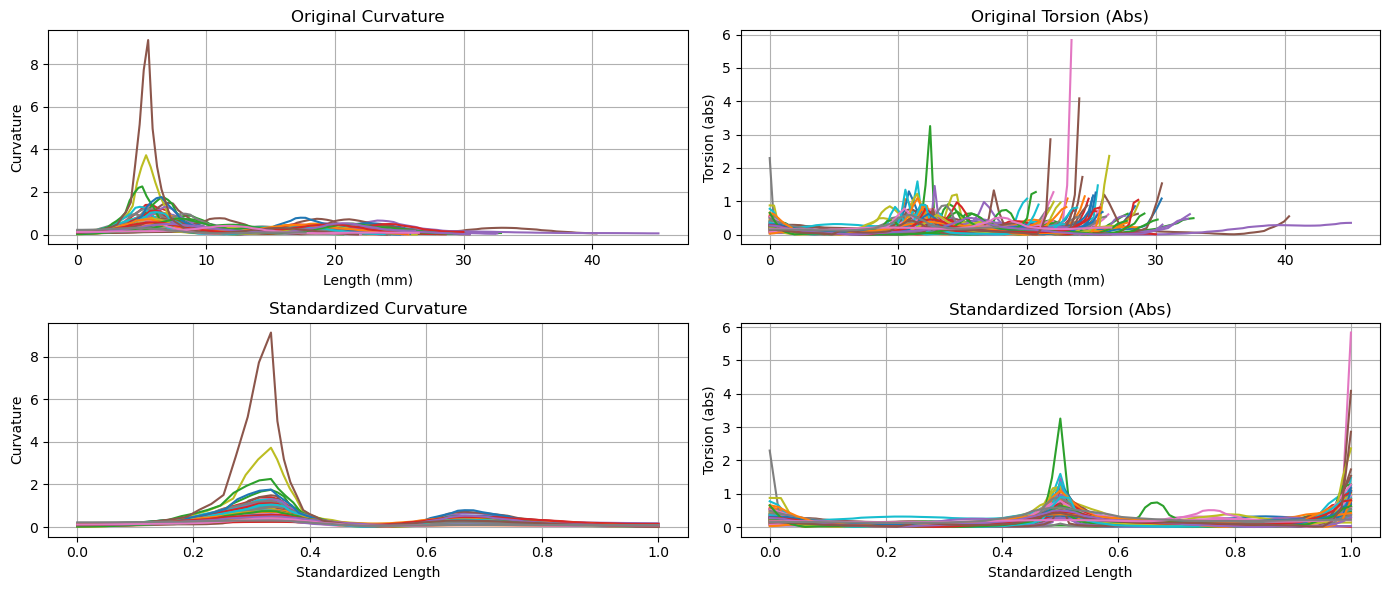

In [3]:
# --------- 设置目录路径 ---------
vtk_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\7_Centerline_Siphon"
vtk_files = sorted([f for f in os.listdir(vtk_dir) if f.endswith(".vtk")])

# --------- 加载单个 VTK 文件 ---------
def load_vtk_data(filepath):
    mesh = pv.read(filepath)
    points = mesh.points
    curvature = mesh.point_data.get("curvature")
    torsion = mesh.point_data.get("torsion")

    if curvature is None or torsion is None:
        return None

    segment_lengths = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)

    return {
        "name": os.path.basename(filepath),
        "lengths": cumulative_length,
        "curvature": curvature,
        "torsion": torsion,
        "points": points
    }

# --------- 查找两个最大峰的位置 ---------
def find_two_peaks(curvatures):
    peaks, _ = find_peaks(curvatures)
    if len(peaks) < 2:
        return None, None
    # 取两个最高峰
    sorted_peaks = sorted(peaks, key=lambda i: curvatures[i], reverse=True)
    return sorted_peaks[0], sorted_peaks[1]

# --------- 加载所有 VTK 数据 --------- 
results = []
for file in vtk_files:
    full_path = os.path.join(vtk_dir, file)
    data = load_vtk_data(full_path)
    if data:
        # 查找两个曲率峰值
        b1_idx, b2_idx = find_two_peaks(data["curvature"])
        if b1_idx is not None and b2_idx is not None:
            b1_idx, b2_idx = sorted([b1_idx, b2_idx])  # 左红右黄
            data["b1_idx"] = b1_idx
            data["b2_idx"] = b2_idx
        results.append(data)

def standardize_length(x, b1_idx, b2_idx):
    """
    将原始长度 x 映射为标准坐标，使得 b1_idx 映射为 1/3，b2_idx 映射为 2/3。
    """
    x0 = x[0]
    x1 = x[b1_idx]
    x2 = x[b2_idx]
    xN = x[-1]

    x_std = np.zeros_like(x)
    for i, xi in enumerate(x):
        if xi <= x1:
            x_std[i] = (xi - x0) / (x1 - x0) * (1 / 3)
        elif xi <= x2:
            x_std[i] = (1 / 3) + (xi - x1) / (x2 - x1) * (1 / 3)
        else:
            x_std[i] = (2 / 3) + (xi - x2) / (xN - x2) * (1 / 3)
    return x_std

# --------- 创建 2×2 子图 ---------
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

# ========== 原始曲率和扭率 ==========

# 原始曲率叠加图
for result in results:
    axes[0, 0].plot(result["lengths"], result["curvature"])
axes[0, 0].set_title("Original Curvature")
axes[0, 0].set_xlabel("Length (mm)")
axes[0, 0].set_ylabel("Curvature")
axes[0, 0].grid(True)
#axes[0, 0].legend(fontsize=8)

# 原始扭率叠加图
for result in results:
    axes[0, 1].plot(result["lengths"], np.abs(result["torsion"]))
axes[0, 1].set_title("Original Torsion (Abs)")
axes[0, 1].set_xlabel("Length (mm)")
axes[0, 1].set_ylabel("Torsion (abs)")
axes[0, 1].grid(True)
#axes[0, 1].legend(fontsize=8)

# ========== 标准化曲率和扭率 ==========

for result in results:
    if "b1_idx" not in result or "b2_idx" not in result:
        continue

    x = result["lengths"]
    y_curv = result["curvature"]
    y_tors = np.abs(result["torsion"])
    name = result["name"]
    b1 = result["b1_idx"]
    b2 = result["b2_idx"]

    # ---------- 标准化曲率（B1 → 1/3，B2 → 2/3） ----------
    x_std = standardize_length(x, b1, b2)
    axes[1, 0].plot(x_std, y_curv[:len(x_std)])

    # ---------- 标准化扭率（主峰 → 0.5，整体长度拉成1） ----------
    peaks, _ = find_peaks(y_tors)
    if len(peaks) > 0:
        mid_peak_idx = sorted(peaks, key=lambda i: abs(i - len(x) // 2))[0]
        total_len = len(x)

        # 构造新的标准坐标，使主峰在0.5，起点为0，终点为1
        x_left = np.linspace(0, 0.5, mid_peak_idx + 1)
        x_right = np.linspace(0.5, 1.0, total_len - mid_peak_idx)
        x_tors_std = np.concatenate([x_left, x_right[1:]])

        axes[1, 1].plot(x_tors_std, y_tors)

axes[1, 0].set_title("Standardized Curvature")
axes[1, 0].set_xlabel("Standardized Length")
axes[1, 0].set_ylabel("Curvature")
axes[1, 0].grid(True)
#axes[1, 0].legend(fontsize=8)

axes[1, 1].set_title("Standardized Torsion (Abs)")
axes[1, 1].set_xlabel("Standardized Length")
axes[1, 1].set_ylabel("Torsion (abs)")
axes[1, 1].grid(True)
#axes[1, 1].legend(fontsize=8)

plt.tight_layout()
#plt.savefig("curvature_torsion_plot.png", dpi=300, bbox_inches="tight")
plt.show()


### 1.2 长度可视化

Centerline Information:
- Number of samples : 78
- Mean length        : 25.34 mm
- Minimum length     : 17.74 mm
- Maximum length     : 45.14 mm


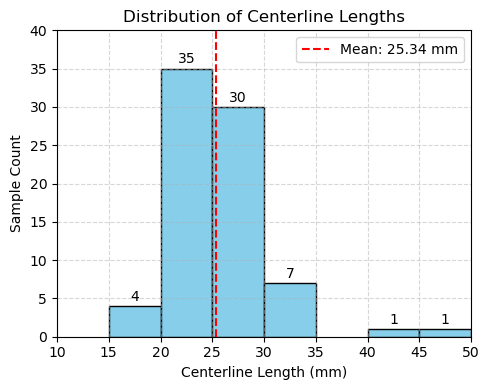

In [4]:
# --------- 统计中心线总长度 ---------
length_list = [r["lengths"][-1] for r in results]  # 每条中心线的总长度

mean_len = np.mean(length_list)
min_len = np.min(length_list)
max_len = np.max(length_list)
range_len = max_len - min_len
n_samples = len(length_list)

print("Centerline Information:")
print(f"- Number of samples : {n_samples}")
print(f"- Mean length        : {mean_len:.2f} mm")
print(f"- Minimum length     : {min_len:.2f} mm")
print(f"- Maximum length     : {max_len:.2f} mm")

# --------- 绘制直方图 ---------
plt.figure(figsize=(5, 4))

# 自定义分布区间（以5为间隔）
bin_width = 5
bins = np.arange(0, max_len + bin_width, bin_width)

# 画直方图（不加 KDE）
counts, bin_edges, patches = plt.hist(length_list, bins=bins, color='skyblue', edgecolor='black')

# 隐藏 count == 0 的柱子 + 添加文字标注
for count, edge_left, edge_right, patch in zip(counts, bin_edges[:-1], bin_edges[1:], patches):
    if count == 0:
        patch.set_visible(False)  # 隐藏
    else:
        x_center = (edge_left + edge_right) / 2
        plt.text(x_center, count + 0.3, f"{int(count)}", ha='center', va='bottom', fontsize=10)

# 添加均值线
plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.2f} mm')

# 设置 x/y 刻度间隔和网格
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.grid(True, linestyle='--', alpha=0.5)

# 设置图形属性
plt.title("Distribution of Centerline Lengths")
plt.xlabel("Centerline Length (mm)")
plt.ylabel("Sample Count")
plt.xlim(10, 50)
plt.ylim(0, 40)
plt.legend()
plt.tight_layout()
plt.show()


## 2 Siphon部分添加 B1 B2 标签

In [5]:
# === 设置路径 ===
input_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\7_Centerline_Siphon"
output_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\8_Centerline_Siphon(with labal)"
output_excel = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\2_Siphon information\1_siphon_bend_informatiion.xlsx"

os.makedirs(output_dir, exist_ok=True)

results = []

# === 遍历所有中心线文件 ===
for fname in os.listdir(input_dir):
    if not fname.endswith(".vtk"):
        continue

    input_path = os.path.join(input_dir, fname)
    model_name = os.path.splitext(fname)[0]
    output_vtk = os.path.join(output_dir, model_name + "_lab.vtk")

    try:
        # === 读取中心线 ===
        centerline = pv.read(input_path)
        points = centerline.points
        curvature = centerline.point_data.get("curvature")

        if curvature is None:
            print(f"⚠️ 跳过 {fname}：未包含 curvature 数据")
            continue

        # === 查找两个主峰 ===
        peaks, _ = find_peaks(curvature, distance=5)
        if len(peaks) < 2:
            print(f"⚠️ {fname} 未找到两个曲率峰，跳过")
            continue

        peak_indices = peaks[np.argsort(curvature[peaks])[-2:]]
        peak_indices.sort()
        p1, p2 = peak_indices
        valley_index = p1 + np.argmin(curvature[p1:p2 + 1])

        # === 添加 lab 字段 ===
        lab = np.zeros(len(curvature), dtype=int)
        lab[:valley_index] = 1
        lab[valley_index + 1:] = 2
        lab[valley_index] = 0

        centerline["lab"] = lab
        centerline.save(output_vtk)

        # === 计算几何参数：段长 + 最大曲率 ===
        def calc_metrics(label_val):
            idx = np.where(lab == label_val)[0]
            if len(idx) < 2:
                return None, None
            seg_pts = points[idx]
            seg_len = np.sum(np.linalg.norm(np.diff(seg_pts, axis=0), axis=1))
            max_curv = np.max(curvature[idx])
            return seg_len, max_curv

        b1_len, b1_maxcurv = calc_metrics(1)
        b2_len, b2_maxcurv = calc_metrics(2)

        results.append({
            "ModelName": model_name,
            "Bend1_Length(mm)": b1_len,
            "Bend1_MaxCurvature(1/mm)": b1_maxcurv,
            "Bend2_Length(mm)": b2_len,
            "Bend2_MaxCurvature(1/mm)": b2_maxcurv
        })

    except Exception as e:
        print(f"❌ 处理 {fname} 失败：{e}")

# === 保存 Excel ===
df = pd.DataFrame(results)
df.to_excel(output_excel, index=False, engine="openpyxl")
#print(f"✅ 所有中心线处理完成，结果保存在：{output_excel}")

